In [47]:
from vit import VisionTransformer
import torch.nn.functional as F
from torch.utils.data import Dataset
import os
import torch
from matplotlib import pyplot as plt
import cv2
from PIL import Image, ImageColor
from torch import nn
from matplotlib.cm import ScalarMappable
from torchvision import transforms 
from torchvision.transforms import Compose, Resize, CenterCrop, ToTensor, Normalize
import matplotlib.pyplot as plt
from trajectory import Trajectory, TrajectoryDataset, extract_fixed_sized_segments, split_into_train_and_test, remove_short_trajectories, get_categories, get_UTK_categories, get_NTU_categories,extract_frames
import pickle
import numpy as np
from sklearn.model_selection import StratifiedShuffleSplit
from einops import rearrange, repeat

from transformer import TubeletTemporalSpatialPart_concat_chan_2_Transformer, \
                TubeletTemporalPart_concat_chan_1_Transformer, TubeletTemporalTransformer, \
                TubeletTemporalPart_mean_chan_1_Transformer, TubeletTemporalPart_mean_chan_2_Transformer,\
                 TubeletTemporalPart_concat_chan_2_Transformer, TemporalTransformer_4, \
                 TemporalTransformer_3, TemporalTransformer_2, BodyPartTransformer, \
                 SpatialTemporalTransformer, TemporalTransformer, Block, Attention, Mlp, ensemble,vit_model

Loading test data file

In [3]:
PIK = "/home/s2765918/code-et/code/data/HRC/trajectories_test_HRC_2D.dat"


with open(PIK, "rb") as f:
    trajectories = pickle.load(f)

Load ViT frames file

In [40]:
frames = np.load("/home/s2765918/code-et/code/npy_data/sorted_data_fullframes/test_all_20_vit16_new_with_idx.npy_sorted.npy")

In [65]:
def getVideoPath(ids,path="/deepstore/datasets/dmb/MachineLearning/HRC/HRC_files/UCF_Videos"):
    # print(ids)
    getVideoFiles = ids
    file = getVideoFiles.split("_")[0]
    
    videoDir = file[:-3] 

    videofile = file +"_x264.mp4"

    video_path = os.path.join(path,videoDir,videofile)

    return video_path

class TrajectoryDataset_(Dataset):
    """
    A dataset to store the trajectories. This should be more efficient than using just arrays.
    Also should be efficient with dataloaders.
    """
    def __init__(self, trajectory_ids, trajectory_videos, trajectory_persons, trajectory_frames, trajectory_categories, X,vit_frames=None):
        self.ids = trajectory_ids.tolist()
        print("list of ids")
        print(len(self.ids))
        self.videos = trajectory_videos.tolist()
        self.persons = trajectory_persons.tolist()
        self.frames = trajectory_frames
        self.categories = trajectory_categories
        self.coordinates = X
        self.vit_frames = vit_frames
        self.path = [getVideoPath(i[0]) for i in self.ids]
        print("Loaded paths and stuffs")
 
    def __len__(self):
        return len(self.ids)
    #frame_idx : if None then take middle frame else select specific frame
    def extract_frames(self,idx,path="/deepstore/datasets/dmb/MachineLearning/HRC/HRC_files/UCF_Videos",frame_idx=None):
        
        frame_list = self.frames[idx]

        cap = cv2.VideoCapture(self.path[idx]) 
        if frame_idx:
            middle_frame = frame_list[frame_idx].item()
        else:
            middle_frame = frame_list[len(frame_list)//2].item()
        
        cap.set(1,middle_frame) 

        ret, frame = cap.read()
        dim = (224,224)

        resized = cv2.resize(frame, dim, interpolation = cv2.INTER_AREA)

        # frame = rearrange(resized,"h w c -> c h w")
        return frame/255.0
        # return torch.from_numpy(resized)/255.0

    def __getitem__(self, idx):
        data = {}
        data['id'] = self.ids[idx] #contains all the videos
        
        data['videos'] = self.videos[idx]
        
        data['persons'] = self.persons[idx]
        data['frames'] = self.frames[idx]
        data['categories'] = self.categories[idx]
        data['coordinates'] = self.coordinates[idx]
        data['path'] = self.path[idx]
        
        # data['context'] = self.context[idx]
        # print("Extracted frames time ")
        # start = time.time()
        # data['extracted_frames'] = self.extract_frames(idx,self.frames[idx])
        data['extracted_frames'] = torch.from_numpy(np.array(self.vit_frames[idx]))

        # data['extracted_frames'] = self.context_frames[idx]
        # print(f"Extracted frames : {abs(start-time.time())}")
        return data
        # return self.ids[idx], self.videos[idx], self.persons[idx], self.frames[idx],self.coordinates[idx], self.categories[idx]

    def trajectory_ids(self):
        return self.ids


Creating the dataset

In [66]:
test_crime_trajectories = remove_short_trajectories(trajectories, input_length=20, input_gap=0, pred_length=0)

In [43]:
test_dataset = TrajectoryDataset_(*extract_fixed_sized_segments("HRC", test_crime_trajectories, input_length=20),vit_frames=frames)

list of ids
844268
Loaded paths and stuffs


Defining Helper functions for visualizing attention

In [179]:
def align_coordinates(coords,img,img_resize=224):
    rx = img_resize/240 #ratio to resize
    ry = img_resize/320 #ration to resize

    # x_values = coords[1::2]
    # y_values = coords[2::2]

    # startcoord_x = int(min(x_values))
    # startcoord_y = int(min(y_values))

    # print(coords[1::2]*rx)

    #Multiply with the ratio for cooridnate alignment
    x_values_ = coords[1::2]*ry
    y_values_ = coords[2::2]*rx

    # endcoord_x = int(max(x_values))
    # endcoord_x = int(max(y_values))



    return x_values_ ,y_values_
    # plt.imshow(img[startcoord_y_:startcoord_y_+endcoord_y_, startcoord_x_:startcoord_x_+endcoord_x_])    


def draw_skeleton(x,y,frame_idx,img):
    #some parts taken from alphapose
    l_pair = [
        (0, 1), (0, 2), (1, 3), (2, 4),  # Head
        (5, 6), (5, 7), (7, 9), (6, 8), (8, 10),
        (17, 11), (17, 12),  # Body
        (11, 13), (12, 14), (13, 15), (14, 16)
    ]
    p_color = [(0, 255, 255), (0, 191, 255), (0, 255, 102), (0, 77, 255), (0, 255, 0),  # Nose, LEye, REye, LEar, REar
        (77, 255, 255), (77, 255, 204), (77, 204, 255), (191, 255, 77), (77, 191, 255), (191, 255, 77),  # LShoulder, RShoulder, LElbow, RElbow, LWrist, RWrist
        (204, 77, 255), (77, 255, 204), (191, 77, 255), (77, 255, 191), (127, 77, 255), (77, 255, 127), (0, 255, 255)]  # LHip, RHip, LKnee, Rknee, LAnkle, RAnkle, Neck
    
    
    line_color = [(0, 215, 255), (0, 255, 204), (0, 134, 255), (0, 255, 50),
        (77, 255, 222), (77, 196, 255), (77, 135, 255), (191, 255, 77), (77, 255, 77),
        (77, 222, 255), (255, 156, 127),
        (0, 127, 255), (255, 127, 77), (0, 77, 255), (255, 77, 36)]
    print("this")
    print(x[0])

    group_pair = {index : (int(x),int(y)) for index , (x,y) in enumerate(zip(x,y),1)}
    
    for start,end in l_pair:
    
        start_ = start-1 if start>1 else start+1
        end_ = end-1 if end>1 else end+1
        start_ = group_pair[start_]
        end_ = group_pair[end_]
        # print(end_)
        # print(group_pair[start_])
        img = cv2.line(img, start_, end_,(0, 255, 255),1)
    return img
    
    #pass
    # 


def calculate_attention(model,block_no,head,frame_idx=None):
    getBlock = model.blocks[block_no]
    attn = getBlock.attn.attn_scores
    if frame_idx:
        getHead =attn[0,head,frame_idx,:]
    else:
        getHead = attn[0,head,:,:]
    # getHead = torch.mean(attn,dim=1)
    # print(getHead.size())
    # print(getHead.size())
    # getHead=  torch.mean(attn,dim=).squeeze()
    # print(attn.size())
    # print(getHead.size())
    # print(getHead_.size())
    # attention.view(1, 1, 28, 28), (224, 224),
    # getHead = interpolate(getHead.view(1, 1, 22, 22),size=(224, 224) ,mode='nearest', align_corners=None, recompute_scale_factor=None, antialias=False).view(224, 224, 1)
    attention_weights = ((getHead -getHead.min()) / (getHead.max() -getHead.min())).detach().numpy()
    # print(getHead.min())
    # F.interpolate(attention.view(1, 1, 28, 28), (224, 224), mode='bilinear').view(224, 224, 1)# plt.imshow(getHead.detach().numpy())
    return getHead,attention_weights

def visualze_attention_img(model,block_no,head,sample_idx,dataset=None,save_path="/home/s2765918/code-et/code/attention_visualize",frame_idx=12): 
    img = test_dataset.extract_frames(sample_idx,dataset[sample_idx]["frames"],frame_idx=frame_idx)
    img = cv2.resize(img, (224,224), interpolation = cv2.INTER_AREA)
    
    
    x,y, = align_coordinates(dataset[sample_idx]["coordinates"],img,img_resize=224)
    img = draw_skeleton(x,y,frame_idx,img)
    img_2 = Image.fromarray((img* 255).astype(np.uint8))
    
    # print(img.shape)
    test_,getattention = calculate_attention(model,block_no,head,frame_idx=frame_idx)
    colormap = plt.cm.get_cmap('jet')
    save_path = os.path.join(save_path,f"sample_{sample_idx}_block_no_{block_no}_head_{head}.png")
    # Overlay the heatmap on the image
    heatmap = colormap(getattention.squeeze())
    heatmap = np.uint8(heatmap * 255)
    # print(heatmap)
    heatmap = cv2.resize(heatmap, (224, 224))

    # plt.imshow(img)
    alpha=0.7
    # plt.imshow(getattention.detach().numpy(), alpha=alpha)
    plt.axis('off')


    # Plot the heatmap as an overlay
    plt.imshow(heatmap, alpha=0.5)
    
    # Add colorbar to show the heatmap intensity scale
    sm = ScalarMappable(cmap=colormap)
    sm.set_array(getattention)
    cbar = plt.colorbar(sm)

    # Show the plot
    plt.axis('off')
    # plt.savefig(save_path, bbox_inches='tight')
    plt.show()

    plt.close()


Loading the model

In [9]:
import torch.nn.functional as F

In [12]:
model_path = "/home/s2765918/code-et/results/HRC/temporal_earlyfusion_all_500_128vitdescriptor_crossattention_fix_2/models/temporal_earlyfusion_all_500_128vitdescriptor_crossattention_fix_2_fold_2.pt"
model = torch.load(model_path,map_location="cpu")

In [69]:
sample_idx=500

In [148]:
coordinates,frames = torch.from_numpy(test_dataset[sample_idx]["coordinates"]).unsqueeze(0),test_dataset[sample_idx]["extracted_frames"]

1800, 500 is a good sample 3200 2300

In [180]:
sample_idx=5300
coordinates,frames = torch.from_numpy(test_dataset[sample_idx]["coordinates"]).unsqueeze(0),test_dataset[sample_idx]["extracted_frames"]
model(coordinates,frames)
block_no = 0
head = 3
visualze_attention_img(model,block_no,head,sample_idx,dataset=test_dataset,frame_idx=10)

[[124.01174   99.40813  140.58093  101.40068  115.4864   150.67722
  124.50404   99.375854 131.43645  100.758896 119.641    105.83428
  131.95773  107.465324 110.05585  100.65988  143.53836  106.579185
  117.90968   97.87694  138.3944   101.06618  118.80726  123.98042
  125.94651  125.23089  118.223976 137.90181  121.41783  138.81433
  115.4864   150.67722  115.03013  151.13347 ]
 [124.84387  118.78225  131.99353  133.9753   136.01523   94.20526
  129.75926   93.758415 136.90894   95.99268  123.50332  100.01437
  137.80264  104.48291  115.45994  105.37662  138.2495   114.313705
  110.991394 109.39831  134.22781  110.73887  120.82219  119.2291
  129.75926  121.46337  119.03477  130.40045  131.99353  131.29416
  119.03477  141.5718   134.22781  142.01865 ]
 [135.7355    94.06335  134.35982   94.98048  143.0725    91.77054
  136.65263   94.06335  144.44818   93.60479  135.27693  100.94179
  147.19957  100.024666 127.02281  102.77603  149.49237  105.527405
  132.067     96.81473  145.36531

TypeError: only size-1 arrays can be converted to Python scalars

In [21]:
model(coordinates,frames)

tensor([[-23.5683,   0.0000, -39.6996, -25.4372, -32.9748, -35.6879, -34.0618,
         -35.0882, -40.0151, -29.2875, -41.2359, -40.3906, -40.5996]],
       grad_fn=<LogSoftmaxBackward0>)

In [146]:
s = F.log_softmax(model(coordinates.unsqueeze(0),frames.unsqueeze(0)))

/tmp/ipykernel_1500125/780230792.py:1: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  s = F.log_softmax(model(coordinates.unsqueeze(0),frames.unsqueeze(0)))


In [147]:
torch.max(s, dim=1)      

torch.return_types.max(
values=tensor([-0.0002], grad_fn=<MaxBackward0>),
indices=tensor([1]))

Load sample idx

In [ ]:
def plot(sample_idx=10):
    coordinates,frames = test_dataset[sample_idx]["coordinates"],test_dataset[sample_idx]["extracted_frames"]
    

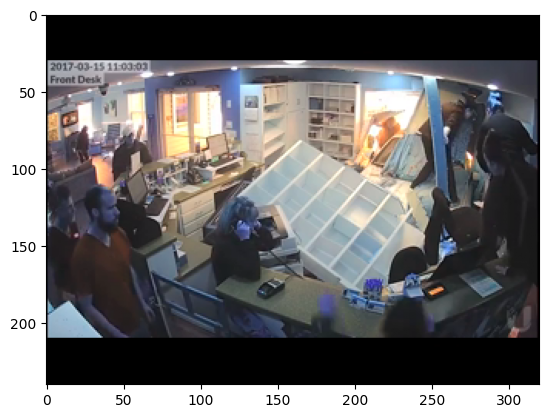

In [30]:
plt.imshow(test_dataset.extract_frames(100010,frame_idx=15))

In [33]:
print(len(y_values))

17


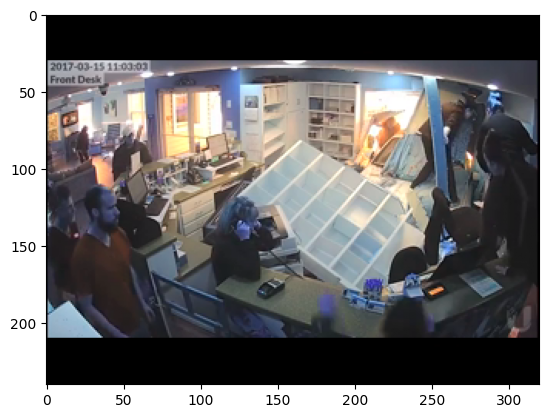

In [12]:
plt.imshow(test_dataset.extract_frames(100010,frame_idx=15))

In [7]:
import matplotlib.pyplot as plt


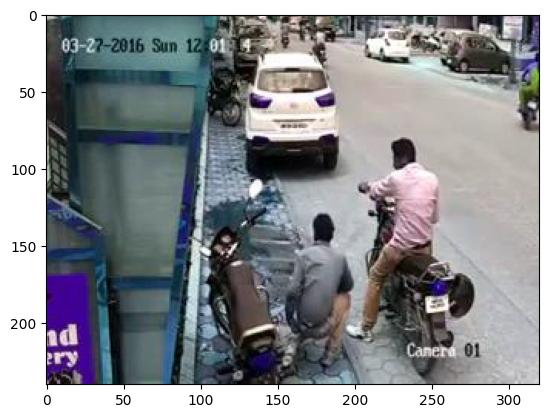

In [103]:
plt.imshow(test_dataset.extract_frames(0,frame_idx=10))

In [101]:
x_values[0]

179.10721

In [ ]:
plt.imshow(img)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


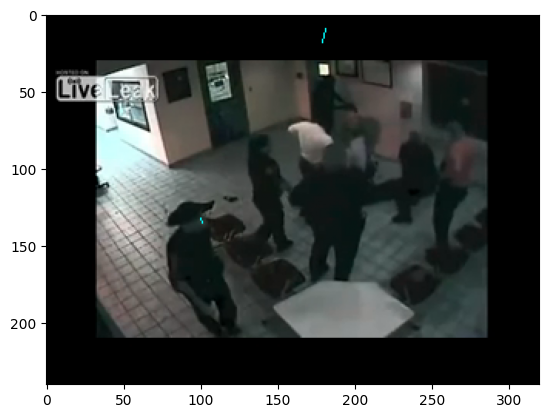

In [123]:
plt.imshow(cv2.line(img, (int(x_values[0]), int(y_values[0])),(int(x_values[1]),int(y_values[1])),(0, 255, 255),1))

In [13]:
l_pair = [
    (0, 1), (0, 2), (1, 3), (2, 4),  # Head
    (5, 6), (5, 7), (7, 9), (6, 8), (8, 10),
    (17, 11), (17, 12),  # Body
    (11, 13), (12, 14), (13, 15), (14, 16)
]
p_color = [(0, 255, 255), (0, 191, 255), (0, 255, 102), (0, 77, 255), (0, 255, 0),  # Nose, LEye, REye, LEar, REar
            (77, 255, 255), (77, 255, 204), (77, 204, 255), (191, 255, 77), (77, 191, 255), (191, 255, 77),  # LShoulder, RShoulder, LElbow, RElbow, LWrist, RWrist
            (204, 77, 255), (77, 255, 204), (191, 77, 255), (77, 255, 191), (127, 77, 255), (77, 255, 127), (0, 255, 255)]  # LHip, RHip, LKnee, Rknee, LAnkle, RAnkle, Neck
line_color = [(0, 215, 255), (0, 255, 204), (0, 134, 255), (0, 255, 50),
                (77, 255, 222), (77, 196, 255), (77, 135, 255), (191, 255, 77), (77, 255, 77),
                (77, 222, 255), (255, 156, 127),
                (0, 127, 255), (255, 127, 77), (0, 77, 255), (255, 77, 36)]

#Some test samples
 24000

In [70]:
get_categories()

['Abuse',
 'Arrest',
 'Arson',
 'Assault',
 'Burglary',
 'Explosion',
 'Fighting',
 'RoadAccidents',
 'Robbery',
 'Shooting',
 'Shoplifting',
 'Stealing',
 'Vandalism']

In [94]:
f = list(np.where(test_dataset.categories == 5)[0])

In [ ]:
f[500:600]

In [77]:
test_dataset.categories[610]

array([5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5])

In [96]:
frame_idx=15 #the segment length
sample_idx = 1658 #sample from the dataet
img = test_dataset.extract_frames(sample_idx,frame_idx=frame_idx)
coordinates = test_dataset[sample_idx]["coordinates"]
x_values = coordinates[frame_idx][0::2]
y_values = coordinates[frame_idx][1::2]
group_pair = {index : (int(x),int(y)) for index , (x,y) in enumerate(zip(x_values,y_values),1)}

In [98]:
for start,end in l_pair:
    
    start_ = start-1 if start>1 else start+1
    end_ = end-1 if end>1 else end+1
    start_ = group_pair[start_]
    end_ = group_pair[end_]
    # print(end_)
    # print(group_pair[start_])
    cv2.line(img, start_, end_,(0, 255, 255),1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


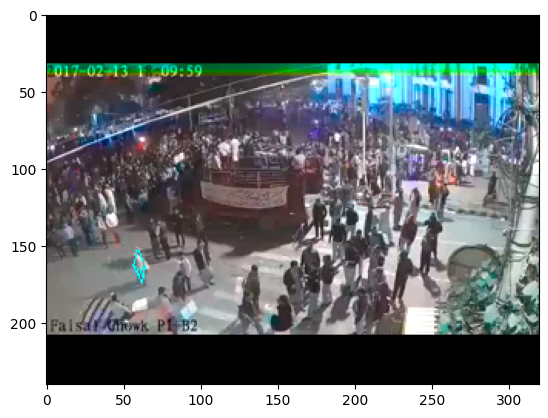

In [99]:
plt.imshow(img)

In [147]:
group_pair

{1: (101, 135),
 2: (100, 132),
 3: (97, 134),
 4: (101, 129),
 5: (90, 135),
 6: (102, 140),
 7: (84, 148),
 8: (120, 134),
 9: (85, 173),
 10: (103, 124),
 11: (100, 189),
 12: (109, 171),
 13: (97, 176),
 14: (117, 187),
 15: (105, 195),
 16: (119, 201),
 17: (113, 206)}

In [68]:
x_values = coordinates[10][0::2]
y_values = coordinates[10][1::2]

In [128]:
len(y_values)

17

In [ ]:
print(x_values)

In [ ]:
print(coordinates[10])

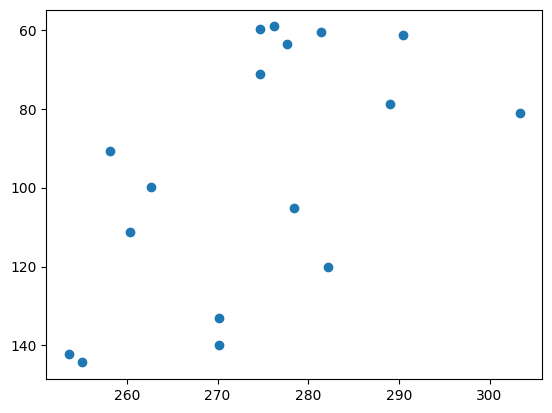

In [74]:
plt.scatter(x_values,y_values)
# plt.plot(x_values, y_values, c='r', linewidth=2) 
plt.gca().invert_yaxis()